In [1]:
import numpy as np
import pandas as pd
#from pandas import DataFrame

import matplotlib

import pickle
import palettable
from scipy.sparse import csr_matrix, vstack
from scipy.optimize import curve_fit
import sys 
from netCDF4 import num2date, date2num
import xarray as xr
from netCDF4 import Dataset

sys.path.append('../../')

from climada.engine import Impact
from climada.entity import Exposures
from climada.hazard import Hazard

from src.impact_calculation.impact_heat import *
from src.util.plots import *

fig_dir = '../../data_analysis/figures/'


## Damage cost for each scenario, year and labor type

In [2]:
#pickle_in = \
#open('../../output/productivity_results/impact_100mc_RCP26_RCP45_RCP85_2020_2035_2050_2065_2080.pickle','rb')
#impact_productivity = pickle.load(pickle_in) 


pickle_in = \
open('../../output/productivity_results/impact_1000mc_RCP26_RCP45_RCP85_2020_2035_2050_2065_2080.pickle','rb')
impact_productivity_2020 = pickle.load(pickle_in) 
impact_productivity.append_years(impact_productivity_2020)

In [6]:
exposures = {}
categories = {'outside high physical activity':'OH','inside low physical activity':'IL',
                 'inside moderate physical activity':'IM','outside moderate physical activity':'OM'}
for category in categories:
    
    exposures[category] = Exposures()
    exposures[category].read_hdf5("".join(['../../input_data/exposures/exposures_productivity_ch_',categories[category],'.h5']))
    exposures[category].gdf['value'] = exposures[category].gdf['value']*8*52*5


2022-07-05 18:07:20,615 - climada.entity.exposures.base - WARNING - The use of Exposures.read_hdf5 is deprecated.Use Exposures.from_hdf5 instead.
2022-07-05 18:07:27,110 - climada.entity.exposures.base - WARNING - The use of Exposures.read_hdf5 is deprecated.Use Exposures.from_hdf5 instead.
2022-07-05 18:07:33,590 - climada.entity.exposures.base - WARNING - The use of Exposures.read_hdf5 is deprecated.Use Exposures.from_hdf5 instead.
2022-07-05 18:07:40,578 - climada.entity.exposures.base - WARNING - The use of Exposures.read_hdf5 is deprecated.Use Exposures.from_hdf5 instead.


In [51]:
impact_table

,level_0,index,latitude,longitude,canton,value_affected_OH,total_value_OH,value_affected_OM,total_value_OM,value_affected_IM,total_value_IM,value_affected_IL,total_value_IL
0,0,432200,46.143553,5.965820,Genève,5790.871351,267033.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.0
1,1,432201,46.145352,5.965771,Genève,0.000000,0.0,0.0,0.0,667.498499,2.095080e+05,0.000000,0.0
2,2,432202,46.147167,5.967017,Genève,5398.441921,248937.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.0
3,3,432203,46.147184,5.968311,Genève,0.000000,0.0,0.0,0.0,0.000000,0.000000e+00,2577.315720,613119.0
4,4,432204,46.146302,5.969629,Genève,0.000000,0.0,0.0,0.0,0.000000,0.000000e+00,1286.768155,307008.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
216095,216095,648295,46.630468,10.455817,Graubünden,249.013076,165360.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.0
216096,216096,648296,46.632266,10.455917,Graubünden,249.013076,165360.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.0
216097,216097,648297,46.633130,10.457272,Graubünden,0.000000,0.0,0.0,0.0,2505.878960,1.164657e+06,0.000000,0.0
216098,216098,648298,46.634029,10.457323,Graubünden,0.000000,0.0,0.0,0.0,630.740738,2.931492e+05,0.000000,0.0


In [60]:
import copy
import os
for rcp in impact_productivity.median_impact_matrices:
    for year in impact_productivity.median_impact_matrices[rcp]:
                impact_IL = impact_productivity.matrix_as_impact(impact_productivity.median_impact_matrices[rcp][year]['inside low physical activity'], exposures['inside low physical activity'])
                impact_IM = impact_productivity.matrix_as_impact(impact_productivity.median_impact_matrices[rcp][year]['inside moderate physical activity'], exposures['inside moderate physical activity'])
                impact_OM = impact_productivity.matrix_as_impact(impact_productivity.median_impact_matrices[rcp][year]['outside moderate physical activity'], exposures['outside moderate physical activity'])
                impact_OH = impact_productivity.matrix_as_impact(impact_productivity.median_impact_matrices[rcp][year]['outside high physical activity'], exposures['outside high physical activity'])




                impact_table = copy.deepcopy(exposures['outside high physical activity'].gdf)

                impact_table['value_affected_OH'] = np.array(impact_OH._build_exp_event(1).gdf['value'])
                impact_table['total_value_OH'] = np.array(exposures['outside high physical activity'].gdf['value'])

                impact_table['value_affected_OM'] = np.array(impact_OM._build_exp_event(1).gdf['value'])
                impact_table['total_value_OM'] = np.array(exposures['outside moderate physical activity'].gdf['value'])
                        
                impact_table['value_affected_IM'] = np.array(impact_IM._build_exp_event(1).gdf['value'])
                impact_table['total_value_IM'] = np.array(exposures['inside moderate physical activity'].gdf['value'])
                
                impact_table['value_affected_IL'] = np.array(impact_IL._build_exp_event(1).gdf['value'])
                impact_table['total_value_IL'] = np.array(exposures['inside low physical activity'].gdf['value'])
                impact_table = impact_table.reset_index(drop=True)

                impact_table =impact_table.drop(columns=['if_heat','geometry','value','centr_heat','category','index_right'])
                file_name = "".join(['heat_related_productivity_loss_yearly_average_estimate_',rcp,'_',str(year),'.csv'])
                path = ('/Users/szelie/OneDrive - ETH Zurich/data/heat_related_mortality_productivity_loss')
                impact_table.to_csv(os.path.join(path,file_name))

In [4]:
impact_high = impact_productivity.matrix_as_impact(impact_productivity.median_impact_matrices['RCP85'][2050]['outside high physical activity'],
                                                            exposures['outside high physical activity'], percentage=True, unit="Productivity Loss [%]")

In [5]:
np.max(impact_high.imp_mat)

1.3932121744324795

/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_59160/1567578578.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "b1ox_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(''.join([fig_dir,'spatial_impact_2050_OH.pdf']),b1ox_inches='tight')


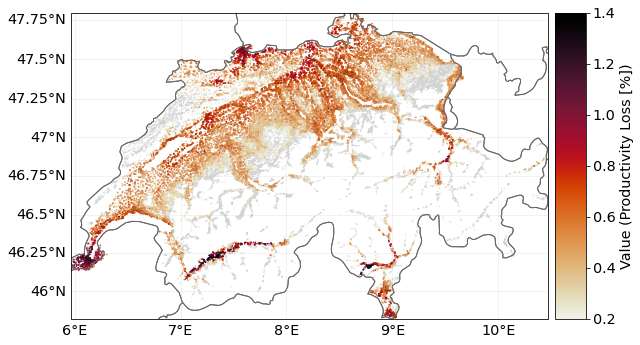

In [10]:
import cartopy.crs as ccrs
import matplotlib
impact_high.plot_hexbin_impact_exposure(pop_name=False,vmin=0.2, vmax=1.4)
plt.savefig(''.join([fig_dir,'spatial_impact_2050_OH.pdf']),b1ox_inches='tight')

In [13]:
categories = {'inside low physical activity': 'IL', 'inside moderate physical activity': 'IM',
                           'outside moderate physical activity': 'OM', 'outside high physical activity': 'OH'}
relative_matrices = impact_productivity.get_relative_change_matrices(2020, 'RCP85', categories)

In [14]:
relative_matrices

{'RCP26': {2020: {'inside low physical activity': <1x216100 sparse matrix of type '<class 'numpy.float64'>'
   	with 216100 stored elements in Compressed Sparse Row format>,
   'inside moderate physical activity': <1x216100 sparse matrix of type '<class 'numpy.float64'>'
   	with 216100 stored elements in Compressed Sparse Row format>,
   'outside moderate physical activity': <1x216100 sparse matrix of type '<class 'numpy.float64'>'
   	with 216100 stored elements in Compressed Sparse Row format>,
   'outside high physical activity': <1x216100 sparse matrix of type '<class 'numpy.float64'>'
   	with 216100 stored elements in Compressed Sparse Row format>},
  2035: {'inside low physical activity': <1x216100 sparse matrix of type '<class 'numpy.float64'>'
   	with 216100 stored elements in Compressed Sparse Row format>,
   'inside moderate physical activity': <1x216100 sparse matrix of type '<class 'numpy.float64'>'
   	with 216100 stored elements in Compressed Sparse Row format>,
   'ou

In [15]:
relative_matrice_high_rcp85 = impact_productivity.matrix_as_impact(relative_matrices['RCP85'][2050]['outside high physical activity'],
                                                            exposures['outside high physical activity'], percentage=False, unit='Relative Change [%]')
relative_matrice_high_rcp26 = impact_productivity.matrix_as_impact(relative_matrices['RCP26'][2050]['outside high physical activity'],
                                                            exposures['outside high physical activity'], percentage=False, unit='Relative Change [%]')


In [16]:
np.max(relative_matrices['RCP85'][2050]['outside high physical activity'])

9319.914105098314

/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


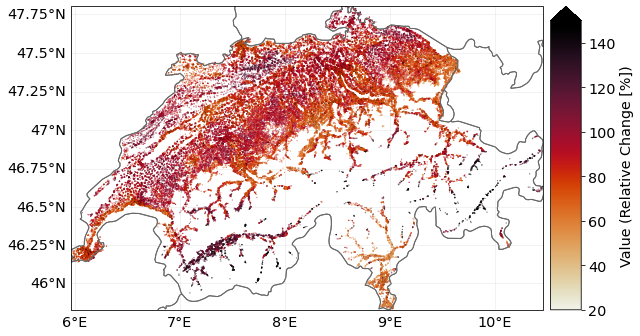

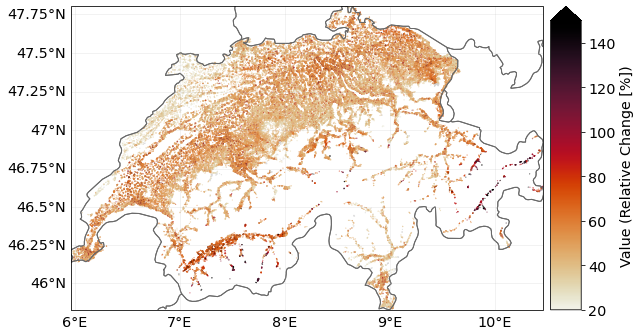

In [19]:
relative_matrice_high_rcp85.plot_hexbin_impact_exposure(pop_name=False, vmin=20, vmax=150, extend='max')
plt.savefig(''.join([fig_dir,'relative_change_2050_OH_rcp86.pdf']),bbox_inches='tight')

relative_matrice_high_rcp26.plot_hexbin_impact_exposure(pop_name=False,
                                                        vmin=20, vmax=150, extend='max')
plt.savefig(''.join([fig_dir,'relative_change_2050_OH_rcp26.pdf']),bbox_inches='tight')

In [14]:
from matplotlib import cycler
IPython_default = plt.rcParams.copy()
colors = cycler('color',
                       ['#EE6666', '#3388BB', '#9988DD',
                        '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
      axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='blue')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

In [108]:
impact_productivity.costs_in_millions()



In [21]:
impact_productivity.median_impact_matrices['RCP26'][2020]['inside low physical activity']

<1x216100 sparse matrix of type '<class 'numpy.float64'>'
	with 123500 stored elements in Compressed Sparse Row format>

In [102]:
np.median(impact_productivity.agg_impacts_mc['RCP85'][2080]['outside high physical activity'])

731614690.6599422

In [22]:
np.quantile(impact_productivity.agg_impacts_mc['RCP85'][2080]['outside high physical activity'],0.9)

2194081339.7370286

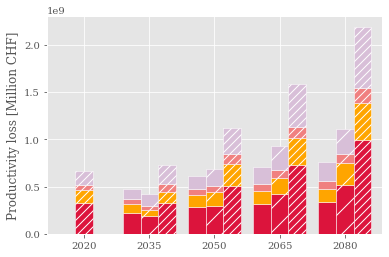

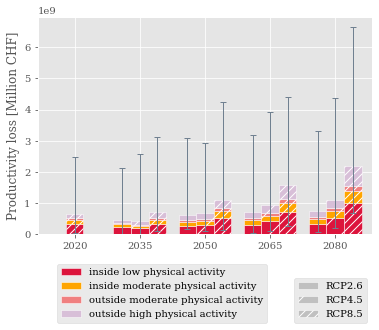

In [12]:
plt.rc('font', family='serif')
with plt.style.context('ggplot'):
    plot_impacts_heat(impact_productivity.agg_impacts_mc, 'Productivity loss [Million CHF]', impact_type='productivity', color=['crimson','orange','lightcoral','thistle'], save=True)



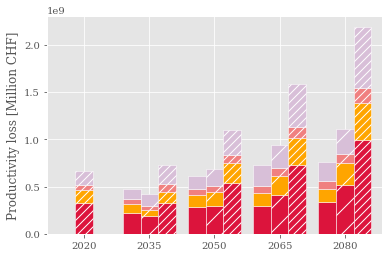

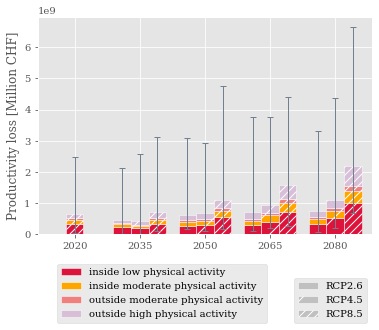

In [14]:
plt.rc('font', family='serif')
with plt.style.context('ggplot'):
    plot_impacts_heat(impact_productivity.agg_impacts_mc, 'Productivity loss [Million CHF]', impact_type='productivity', color=['crimson','orange','lightcoral','thistle'], save=True)


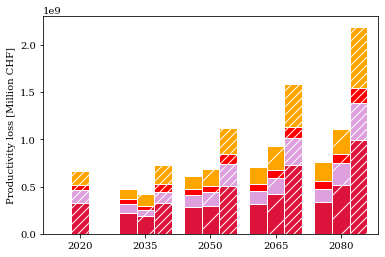

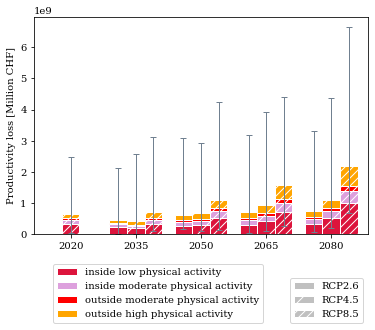

In [5]:
plot_impacts_heat(impact_productivity.agg_impacts_mc, 'Productivity loss [Million CHF]', impact_type='productivity', color=['crimson','plum','red','orange'], save=True)


In [15]:
print(np.sum(impact_productivity.agg_impacts_mc['RCP85'][2050].quantile(0.05))/1000000)
print(np.sum(impact_productivity.agg_impacts_mc['RCP85'][2020].median())/1000000)
print(np.sum(impact_productivity.agg_impacts_mc['RCP85'][2050].quantile(0.95))/1000000)


185.25999925032446
665.1011130442885
4766.154264184903


In [24]:
print(np.sum(impact_productivity.agg_impacts_mc['RCP85'][2080].median())/1000000-np.sum(impact_productivity.agg_impacts_mc['RCP26'][2080].median())/1000000)



1381.9623562053393


In [26]:
(np.sum(impact_productivity.agg_impacts_mc['RCP85'][2080].median())/1000000-np.sum(impact_productivity.agg_impacts_mc['RCP26'][2080].median())/1000000)/np.sum(impact_productivity.agg_impacts_mc['RCP26'][2080].median()/1000000)



1.7050781625730151

In [ ]:
print((np.sum(impact_productivity.agg_impacts_mc['RCP85']['2050'].quantile(0.95))/(np.sum(impact_productivity.agg_impacts_mc['RCP85']['2050'].quantile(0.5)))))


In [39]:
total = np.sum(impact_productivity.agg_impacts_mc['RCP85'][2050][cat].median() for cat in impact_productivity.agg_impacts_mc['RCP85'][2050])
il_percent = 100*impact_productivity.agg_impacts_mc['RCP85'][2050]['inside low physical activity'].median()/(exposures['inside low physical activity'].gdf.value.sum())
oh_percent = 100*impact_productivity.agg_impacts_mc['RCP85'][2050]['outside high physical activity'].median()/(exposures['outside high physical activity'].gdf.value.sum())
om_percent = 100*impact_productivity.agg_impacts_mc['RCP85'][2050]['outside moderate physical activity'].median()/(exposures['outside moderate physical activity'].gdf.value.sum())
im_percent = 100*impact_productivity.agg_impacts_mc['RCP85'][2050]['inside moderate physical activity'].median()/(exposures['inside moderate physical activity'].gdf.value.sum())
total_percent = 100*total/((exposures['inside low physical activity'].gdf.value.sum()+exposures['outside high physical activity'].gdf.value.sum()+exposures['outside moderate physical activity'].gdf.value.sum()+exposures['inside moderate physical activity'].gdf.value.sum()))



/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_59160/3263190642.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total = np.sum(impact_productivity.agg_impacts_mc['RCP85'][2050][cat].median() for cat in impact_productivity.agg_impacts_mc['RCP85'][2050])


In [53]:
il_percent

0.21758632649156873

In [63]:
s = 'RCP85'
y=2080

total = np.sum(impact_productivity.agg_impacts_mc[s][y][cat].median() for cat in impact_productivity.agg_impacts_mc[s][y])

impact_productivity.agg_impacts_mc[s][y]['outside high physical activity'].median()/total



/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_59160/1649365672.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total = np.sum(impact_productivity.agg_impacts_mc[s][y][cat].median() for cat in impact_productivity.agg_impacts_mc[s][y])


0.29494919082255755

In [50]:
total/1000000

1102.7181493263051

In [71]:
def median_loss(impacts, scenario, year, category='all'):
    if category=='all':
        median_loss = [np.median(impacts.agg_impacts_mc[scenario][year][cat]) for cat in impacts.agg_impacts_mc[scenario][year]]
    else:    
        median_loss = np.median(impacts.agg_impacts_mc[scenario][year][category])
    return median_loss

def percentile_loss(impacts, scenario, year, percentile, category='all'):
    if category=='all':
        percentile_loss = (np.percentile([impacts.agg_impacts_mc[scenario][year][cat] for cat in impacts.agg_impacts_mc[scenario][year]], percentile))
    else:    
        percentile_loss = np.percentile(impacts.agg_impacts_mc[scenario][year][category],percentile)
    return percentile_loss

def max_loss(impacts, scenario, year, category='all'):
    if category=='all':
        max_loss = [np.max(impacts.agg_impacts_mc[scenario][year][cat]) for cat in impacts.agg_impacts_mc[scenario][year]]

    else:    
        max_loss = np.max(impacts.agg_impacts_mc[scenario][year][category])

    return max_loss

In [88]:
percentile_loss(impact_productivity,'RCP85',2050,0.5, category )

74426.24712258602

## table with cantonal values

In [90]:
categories_short = {'inside low physical activity': 'IL', 'inside moderate physical activity': 'IM',
                           'outside moderate physical activity': 'OM', 'outside high physical activity': 'OH'}
impact_productivity.median_impact_matrices['RCP26'][2020]=impact_productivity.median_impact_matrices['RCP26'][2080]
cantonal_impacts_df = impact_productivity.cantonal_impacts_df(exposures, scenarios=['RCP26', 'RCP85'], years=[2020,2050,2080])


In [ ]:
cantonal_impacts_df

In [92]:
cantonal_impacts_df_total = cantonal_impacts_df.groupby(level=[0,1], axis=1).sum().astype(int)
cantonal_impacts_df_total.insert(0, 'Baseline (2020)', cantonal_impacts_df_total['RCP8.5'][2020])
cantonal_impacts_df_total = cantonal_impacts_df_total.drop(columns=2020,level=1)
#print(cantonal_impacts_df_total)

In [93]:
cantonal_impacts_df_total = cantonal_impacts_df_total/1000000

In [94]:
cantonal_impacts_df_total=cantonal_impacts_df_total.round(decimals=2)

In [95]:
with pd.option_context("max_colwidth", 1000):
    print(cantonal_impacts_df_total.to_latex(multicolumn=True))

\begin{tabular}{lrrrrr}
\toprule
{} & Baseline (2020) & \multicolumn{2}{l}{RCP2.6} & \multicolumn{2}{l}{RCP8.5} \\
{} &    2050 &    2080 &     2050 &     2080 \\
canton                 &                 &         &         &          &          \\
\midrule
Aargau                 &           48.12 &   54.11 &   60.39 &    79.52 &   156.64 \\
Appenzell Ausserrhoden &            2.31 &    2.54 &    2.91 &     3.76 &     7.76 \\
Appenzell Innerrhoden  &            0.73 &    0.82 &    0.92 &     1.19 &     2.56 \\
Basel-Landschaft       &           22.47 &   24.66 &   27.61 &    37.18 &    71.32 \\
Basel-Stadt            &           26.66 &   27.73 &   31.43 &    44.20 &    81.74 \\
Bern                   &           74.67 &   79.91 &   90.67 &   120.04 &   242.53 \\
Fribourg               &           18.41 &   20.44 &   22.76 &    30.13 &    61.66 \\
Genève                 &           56.00 &   61.26 &   69.50 &    93.46 &   179.30 \\
Glarus                 &            2.21 &    2.45 &  

/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_59160/3776204636.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cantonal_impacts_df_total.to_latex(multicolumn=True))
